# Day_084

### 練習時間
請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
from keras.models import Sequential, Model
from keras.layers import Input, Dense
from keras import optimizers
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

In [3]:
# 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
# Hint 1 : 在 Dense 層中增加 Regularizers
# Hint 2 : 增加 Dropout 層並設定 dropout ratio 
# Hint 3 : 增加 Batch-normalization 層
from keras.regularizers import l1, l2, l1_l2
from keras.layers import BatchNormalization, Activation, Dropout
def build_mlp(input_shape, output_units = 10, num_neurons=[512, 256, 128], Regu_ratio = 1e-4, drp_ratio = 0.2):
    input_layer = Input(input_shape)   
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = Dense(units = n_units, 
                      activation = "relu", 
                      name = "hidden_layer" + str(i+1),
                      kernel_regularizer = l1_l2(Regu_ratio))(input_layer)
            x = Dropout(drp_ratio)(x)
            
        else:
            x = Dense(units = n_units, 
                      activation = "relu", 
                      name = "hidden_layer" + str(i+1),
                      kernel_regularizer = l1_l2(Regu_ratio))(x)
            x = Dropout(drp_ratio)(x)
            x = BatchNormalization()(x)
    
    output = Dense(units = output_units, activation = "softmax", name = "output")(x)
    
    model = Model(inputs = [input_layer], outputs = [output])
    return model

In [6]:
def plt_model_result(result):
    num_colors = len(result.keys())
    cm = plt.get_cmap('gist_rainbow')
    color_bar = [cm(1. * i/num_colors) for i in range(num_colors)]
    
    plt.figure(figsize=(12, 10))
    for i, cond in enumerate(result.keys()):
        plt.plot(range(len(result[cond]['train-loss'])), result[cond]['train-loss'], '-', label = 'train-' + cond, color = color_bar[i])
        plt.plot(range(len(result[cond]['valid-loss'])), result[cond]['valid-loss'], '--', label = 'valid-' + cond, color = color_bar[i])
    plt.title("Loss")
    plt.legend(loc = 'center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
    plt.figure(figsize=(12, 10))
    for i, cond in enumerate(results.keys()):
        plt.plot(range(len(result[cond]['train-acc'])), result[cond]['train-acc'], '-', label = 'train-' + cond, color = color_bar[i])
        plt.plot(range(len(result[cond]['valid-acc'])), result[cond]['valid-acc'], '--', label = 'valid-' + cond, color = color_bar[i])
    plt.title("Accuracy")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [7]:
# 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = [512, 1024]
MOMENTUM = 0.95
L1_L2_EXP = [1e-8, 1e-12]
Dropout_EXP = [0.2, 0.4]

In [8]:
results = {}
for batch_size, regularizer_ratio, drop_rate in itertools.product(BATCH_SIZE, L1_L2_EXP, Dropout_EXP):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with BATCH_SIZE : %.0f, Regularizer : %.12f, Dropout : %.2f" % (batch_size,regularizer_ratio,drop_rate))
    model = build_mlp(input_shape = x_train.shape[1:], Regu_ratio = regularizer_ratio, drp_ratio = drop_rate)
    model.summary()
    optimizer = optimizers.Adam(lr = LEARNING_RATE)
    model.compile(loss = "categorical_crossentropy", metrics = ["accuracy"], optimizer = optimizer)

    model.fit(x_train, y_train, 
              epochs = EPOCHS, 
              batch_size = batch_size, 
              validation_data = (x_test, y_test), 
              shuffle = True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = f'l1_l2:{str(regularizer_ratio)}, Dropout: {str(drop_rate)}, Batch_Size:{str(batch_size)}' 
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with BATCH_SIZE : 512, Regularizer : 0.000000010000, Dropout : 0.20
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_______________________________________________________________

Epoch 47/50
50000/50000 [==============================] - 35s 690us/step - loss: 1.7893 - acc: 0.3872 - val_loss: 1.7952 - val_acc: 0.3907
Epoch 48/50
50000/50000 [==============================] - 34s 680us/step - loss: 1.7910 - acc: 0.3838 - val_loss: 1.8198 - val_acc: 0.3676
Epoch 49/50
50000/50000 [==============================] - 34s 676us/step - loss: 1.7859 - acc: 0.3842 - val_loss: 1.8453 - val_acc: 0.3556
Epoch 50/50
50000/50000 [==============================] - 34s 673us/step - loss: 1.7917 - acc: 0.3854 - val_loss: 1.8912 - val_acc: 0.3523
Experiment with BATCH_SIZE : 512, Regularizer : 0.000000010000, Dropout : 0.40
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_______________________________

Epoch 43/50
50000/50000 [==============================] - 34s 672us/step - loss: 1.9452 - acc: 0.3093 - val_loss: 2.0368 - val_acc: 0.2807
Epoch 44/50
50000/50000 [==============================] - 34s 674us/step - loss: 1.9393 - acc: 0.3107 - val_loss: 2.1252 - val_acc: 0.2584
Epoch 45/50
50000/50000 [==============================] - 34s 678us/step - loss: 1.9435 - acc: 0.3079 - val_loss: 2.0717 - val_acc: 0.2807
Epoch 46/50
50000/50000 [==============================] - 34s 672us/step - loss: 1.9419 - acc: 0.3067 - val_loss: 2.0760 - val_acc: 0.2745
Epoch 47/50
50000/50000 [==============================] - 34s 681us/step - loss: 1.9567 - acc: 0.3070 - val_loss: 2.1354 - val_acc: 0.2691
Epoch 48/50
50000/50000 [==============================] - 34s 674us/step - loss: 1.9562 - acc: 0.3036 - val_loss: 1.9851 - val_acc: 0.2902
Epoch 49/50
50000/50000 [==============================] - 35s 708us/step - loss: 1.9385 - acc: 0.3105 - val_loss: 2.0385 - val_acc: 0.2947
Epoch 50/50
50000/50

Epoch 39/50
50000/50000 [==============================] - 34s 678us/step - loss: 1.7827 - acc: 0.3907 - val_loss: 1.8213 - val_acc: 0.3607
Epoch 40/50
50000/50000 [==============================] - 34s 684us/step - loss: 1.7784 - acc: 0.3904 - val_loss: 1.7481 - val_acc: 0.4027
Epoch 41/50
50000/50000 [==============================] - 34s 681us/step - loss: 1.7772 - acc: 0.3929 - val_loss: 1.7935 - val_acc: 0.3867
Epoch 42/50
50000/50000 [==============================] - 34s 680us/step - loss: 1.7709 - acc: 0.3935 - val_loss: 1.7085 - val_acc: 0.4138
Epoch 43/50
50000/50000 [==============================] - 34s 681us/step - loss: 1.7722 - acc: 0.3932 - val_loss: 1.7026 - val_acc: 0.4170
Epoch 44/50
50000/50000 [==============================] - 34s 682us/step - loss: 1.7835 - acc: 0.3922 - val_loss: 1.7629 - val_acc: 0.3905
Epoch 45/50
50000/50000 [==============================] - 34s 679us/step - loss: 1.7838 - acc: 0.3894 - val_loss: 1.8100 - val_acc: 0.3836
Epoch 46/50
50000/50

Epoch 35/50
50000/50000 [==============================] - 34s 684us/step - loss: 1.9570 - acc: 0.2985 - val_loss: 2.0531 - val_acc: 0.3008
Epoch 36/50
50000/50000 [==============================] - 34s 683us/step - loss: 1.9627 - acc: 0.2966 - val_loss: 2.1879 - val_acc: 0.2221
Epoch 37/50
50000/50000 [==============================] - 34s 684us/step - loss: 1.9600 - acc: 0.2990 - val_loss: 2.0811 - val_acc: 0.2733
Epoch 38/50
50000/50000 [==============================] - 34s 676us/step - loss: 1.9573 - acc: 0.2974 - val_loss: 2.0189 - val_acc: 0.2925
Epoch 39/50
50000/50000 [==============================] - 34s 684us/step - loss: 1.9629 - acc: 0.2962 - val_loss: 1.9895 - val_acc: 0.3163
Epoch 40/50
50000/50000 [==============================] - 34s 680us/step - loss: 1.9680 - acc: 0.2940 - val_loss: 2.0276 - val_acc: 0.2804
Epoch 41/50
50000/50000 [==============================] - 34s 685us/step - loss: 1.9593 - acc: 0.3002 - val_loss: 1.9782 - val_acc: 0.3087
Epoch 42/50
50000/50

Epoch 31/50
50000/50000 [==============================] - 31s 630us/step - loss: 1.7148 - acc: 0.4183 - val_loss: 1.6763 - val_acc: 0.4391
Epoch 32/50
50000/50000 [==============================] - 32s 637us/step - loss: 1.7070 - acc: 0.4220 - val_loss: 1.7456 - val_acc: 0.4012
Epoch 33/50
50000/50000 [==============================] - 31s 622us/step - loss: 1.7144 - acc: 0.4207 - val_loss: 1.7182 - val_acc: 0.4227
Epoch 34/50
50000/50000 [==============================] - 31s 627us/step - loss: 1.7060 - acc: 0.4212 - val_loss: 1.7016 - val_acc: 0.4197
Epoch 35/50
50000/50000 [==============================] - 31s 627us/step - loss: 1.7077 - acc: 0.4166 - val_loss: 1.7232 - val_acc: 0.4214
Epoch 36/50
50000/50000 [==============================] - 32s 630us/step - loss: 1.6972 - acc: 0.4245 - val_loss: 1.7052 - val_acc: 0.4233
Epoch 37/50
50000/50000 [==============================] - 33s 660us/step - loss: 1.7125 - acc: 0.4180 - val_loss: 1.6720 - val_acc: 0.4333
Epoch 38/50
50000/50

Epoch 27/50
50000/50000 [==============================] - 16s 317us/step - loss: 1.8808 - acc: 0.3417 - val_loss: 1.8977 - val_acc: 0.3408
Epoch 28/50
50000/50000 [==============================] - 16s 313us/step - loss: 1.8886 - acc: 0.3406 - val_loss: 1.9882 - val_acc: 0.3015
Epoch 29/50
50000/50000 [==============================] - 16s 313us/step - loss: 1.8848 - acc: 0.3416 - val_loss: 1.9569 - val_acc: 0.3421
Epoch 30/50
50000/50000 [==============================] - 16s 314us/step - loss: 1.8752 - acc: 0.3473 - val_loss: 1.9003 - val_acc: 0.3577
Epoch 31/50
50000/50000 [==============================] - 16s 314us/step - loss: 1.8898 - acc: 0.3398 - val_loss: 1.9102 - val_acc: 0.3591
Epoch 32/50
50000/50000 [==============================] - 16s 314us/step - loss: 1.8784 - acc: 0.3442 - val_loss: 1.8798 - val_acc: 0.3712
Epoch 33/50
50000/50000 [==============================] - 17s 331us/step - loss: 1.8830 - acc: 0.3415 - val_loss: 1.9211 - val_acc: 0.3487
Epoch 34/50
50000/50

Epoch 23/50
50000/50000 [==============================] - 16s 311us/step - loss: 1.7403 - acc: 0.4134 - val_loss: 1.7365 - val_acc: 0.4218
Epoch 24/50
50000/50000 [==============================] - 16s 311us/step - loss: 1.7260 - acc: 0.4168 - val_loss: 1.6836 - val_acc: 0.4316
Epoch 25/50
50000/50000 [==============================] - 16s 314us/step - loss: 1.7296 - acc: 0.4149 - val_loss: 1.7684 - val_acc: 0.4117
Epoch 26/50
50000/50000 [==============================] - 16s 313us/step - loss: 1.7263 - acc: 0.4145 - val_loss: 1.6635 - val_acc: 0.4335
Epoch 27/50
50000/50000 [==============================] - 16s 314us/step - loss: 1.7138 - acc: 0.4226 - val_loss: 1.6956 - val_acc: 0.4300
Epoch 28/50
50000/50000 [==============================] - 16s 313us/step - loss: 1.7118 - acc: 0.4215 - val_loss: 1.6610 - val_acc: 0.4380
Epoch 29/50
50000/50000 [==============================] - 16s 314us/step - loss: 1.7150 - acc: 0.4210 - val_loss: 1.7201 - val_acc: 0.4213
Epoch 30/50
50000/50

Epoch 19/50
50000/50000 [==============================] - 16s 313us/step - loss: 1.9096 - acc: 0.3365 - val_loss: 1.8991 - val_acc: 0.3706
Epoch 20/50
50000/50000 [==============================] - 16s 314us/step - loss: 1.9131 - acc: 0.3369 - val_loss: 2.0240 - val_acc: 0.2967
Epoch 21/50
50000/50000 [==============================] - 16s 315us/step - loss: 1.9172 - acc: 0.3354 - val_loss: 1.8556 - val_acc: 0.3761
Epoch 22/50
50000/50000 [==============================] - 16s 314us/step - loss: 1.9080 - acc: 0.3346 - val_loss: 1.9974 - val_acc: 0.3091
Epoch 23/50
50000/50000 [==============================] - 16s 314us/step - loss: 1.9188 - acc: 0.3319 - val_loss: 1.9819 - val_acc: 0.3187
Epoch 24/50
50000/50000 [==============================] - 16s 315us/step - loss: 1.9081 - acc: 0.3334 - val_loss: 1.9408 - val_acc: 0.3450
Epoch 25/50
50000/50000 [==============================] - 16s 317us/step - loss: 1.9034 - acc: 0.3345 - val_loss: 1.9343 - val_acc: 0.3429
Epoch 26/50
50000/50

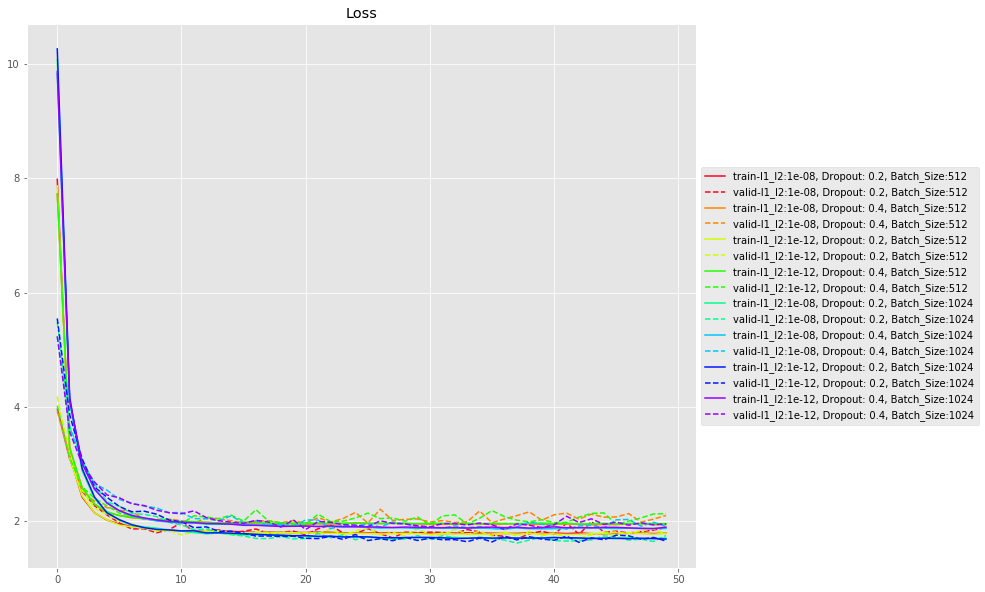

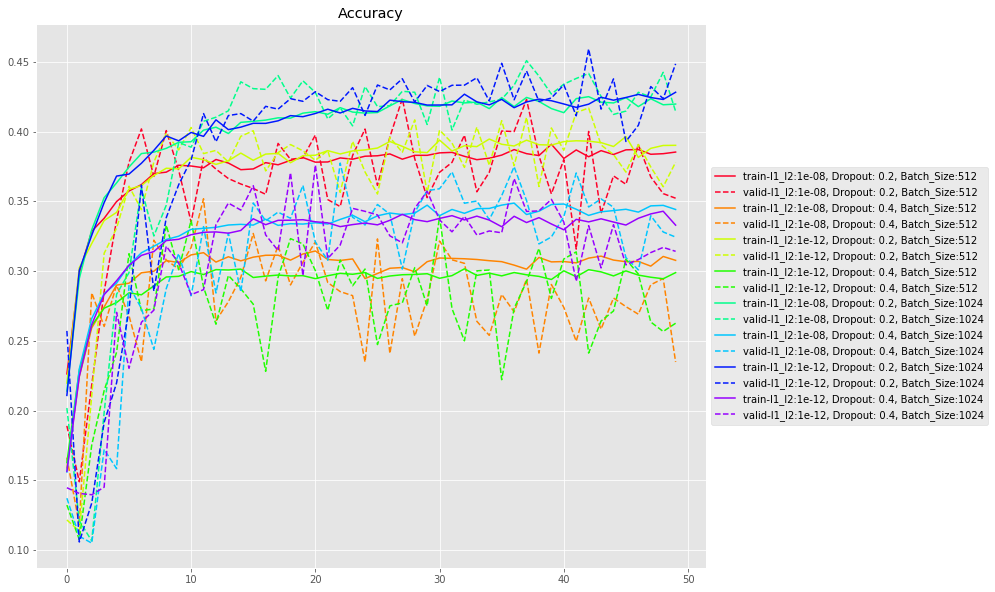

In [9]:
plt_model_result(results)